# Fully Convolutional Watershed Distance Transform for 2D Data
---
Implementation of papers:

[Deep Watershed Transform for Instance Segmentation](http://openaccess.thecvf.com/content_cvpr_2017/papers/Bai_Deep_Watershed_Transform_CVPR_2017_paper.pdf)

[Learn to segment single cells with deep distance estimator and deep cell detector](https://arxiv.org/abs/1803.10829)

In [1]:
import os
import errno

import numpy as np

import sys
sys.path.insert(0,"/home/snn/deepcell-tf")

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)


import deepcell

In [2]:
import math
import numpy as np
from tensorflow.python.keras import backend as K
from tensorflow.python.keras import callbacks
from tensorflow.python.keras.optimizers import SGD

from tensorflow.python.keras.utils.data_utils import get_file

from deepcell import losses
import image_gen as image_gen
from deepcell import image_generators
from deepcell import model_zoo
from deepcell.layers import TensorProduct, ReflectionPadding3D, DilatedMaxPool3D

from deepcell.utils import train_utils
from deepcell.utils.data_utils import get_data
from deepcell.utils.train_utils import rate_scheduler
from deepcell.training import train_model_conv


from tensorflow.python.keras.layers import MaxPool3D
from conv_gru_layer import ConvGRU2D
from tensorflow.python.keras.layers import BatchNormalization, Dropout, LeakyReLU
from tensorflow.python.keras.layers import Conv3D, ZeroPadding3D, ConvLSTM2D, Cropping3D
from tensorflow.python.keras.layers import Input, Add, Concatenate, Flatten, Reshape
from tensorflow.python.keras.engine.input_layer import InputLayer

from tensorflow.python.keras.models import Model


from tensorflow.python.keras.regularizers import l2
from deepcell.layers import ImageNormalization2D, ImageNormalization3D
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Activation, Softmax

from sklearn.model_selection import train_test_split

from tensorflow.python.client import device_lib

### Load the Training Data

In [3]:
# If DATA_FILE exists just run this cell

from deepcell.utils.data_utils import get_data

DATA_DIR = '/data/npz_data/tracking_benchmark_data'
DATA_FILE = os.path.join(DATA_DIR, '3T3_HeLa_HEK_RAW_cropped.npz')
# DATA_FILE = os.path.join(DATA_DIR, '3T3_HeLa_HEK_RAW_V2_stacked.npz')

# Load Information for hardcoded image size training
seed = 1
test_size = .2
train_dict, test_dict = get_data(DATA_FILE, seed=seed, test_size=test_size)
X_train, y_train = train_dict['X'], train_dict['y']
X_test, y_test = test_dict['X'], test_dict['y']

print(' -\nX.shape: {}\ny.shape: {}'.format(train_dict['X'].shape, train_dict['y'].shape))

 -
X.shape: (642, 30, 135, 160, 1)
y.shape: (642, 30, 135, 160, 1)


### Set up filepath constants

In [4]:
# Set up other required filepaths
PREFIX = os.path.relpath(os.path.dirname(DATA_FILE), DATA_DIR)
ROOT_DIR = '/data' # mounted volume
MODEL_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'models', PREFIX))
LOG_DIR = os.path.abspath(os.path.join(ROOT_DIR, 'logs', PREFIX))

## Define feature net models

#### feature_net_3D is the gru analog of bn_feature_net_3D

In [5]:
def feature_net_3D(receptive_field=61,
                    n_frames=5,
                    input_shape=(5, 256, 256, 1),
                    n_features=3,
                    n_channels=1,
                    reg=1e-5,
                    n_conv_filters=64,
                    n_dense_filters=200,
                    VGG_mode=False,
                    init='he_normal',
                    norm_method='std',
                    location=False,
                    dilated=False,
                    padding=False,
                    padding_mode='reflect',
                    multires=False,
                    include_top=True,
                    gru=False,
                    gru_kernel_size =3):
    # Create layers list (x) to store all of the layers.
    # We need to use the functional API to enable the multiresolution mode
    x = []

    win = (receptive_field - 1) // 2
    win_z = (n_frames - 1) // 2

    if dilated:
        padding = True

    if K.image_data_format() == 'channels_first':
        channel_axis = 1
        time_axis = 2
        row_axis = 3
        col_axis = 4
        if not dilated:
            input_shape = (n_channels, n_frames, receptive_field, receptive_field)
    else:
        channel_axis = -1
        time_axis = 1
        row_axis = 2
        col_axis = 3
        if not dilated:
            input_shape = (n_frames, receptive_field, receptive_field, n_channels)

    x.append(Input(shape=input_shape))
    x.append(ImageNormalization3D(norm_method=norm_method,
                                  filter_size=receptive_field)(x[-1]))

    if padding:
        if padding_mode == 'reflect':
            x.append(ReflectionPadding3D(padding=(win_z, win, win))(x[-1]))
        elif padding_mode == 'zero':
            x.append(ZeroPadding3D(padding=(win_z, win, win))(x[-1]))

    if location:
        x.append(Location3D(in_shape=tuple(x[-1].shape.as_list()[1:]))(x[-1]))
        x.append(Concatenate(axis=channel_axis)([x[-2], x[-1]]))

    layers_to_concat = []

    rf_counter = receptive_field
    block_counter = 0
    d = 1

    while rf_counter > 4:
        filter_size = 3 if rf_counter % 2 == 0 else 4
        x.append(Conv3D(n_conv_filters, (1, filter_size, filter_size),
                        dilation_rate=(1, d, d), kernel_initializer=init,
                        padding='valid', kernel_regularizer=l2(reg))(x[-1]))
        x.append(BatchNormalization(axis=channel_axis)(x[-1]))
        x.append(Activation('relu')(x[-1]))

        block_counter += 1
        rf_counter -= filter_size - 1

        if block_counter % 2 == 0:
            if dilated:
                x.append(DilatedMaxPool3D(dilation_rate=(1, d, d),
                                          pool_size=(1, 2, 2))(x[-1]))
                d *= 2
            else:
                x.append(MaxPool3D(pool_size=(1, 2, 2))(x[-1]))

            if VGG_mode:
                n_conv_filters *= 2

            rf_counter = rf_counter // 2

            if multires:
                layers_to_concat.append(len(x) - 1)

    if multires:
        c = []
        for l in layers_to_concat:
            output_shape = x[l].get_shape().as_list()
            target_shape = x[-1].get_shape().as_list()
            time_crop = (0, 0)

            row_crop = int(output_shape[row_axis] - target_shape[row_axis])

            if row_crop % 2 == 0:
                row_crop = (row_crop // 2, row_crop // 2)
            else:
                row_crop = (row_crop // 2, row_crop // 2 + 1)

            col_crop = int(output_shape[col_axis] - target_shape[col_axis])

            if col_crop % 2 == 0:
                col_crop = (col_crop // 2, col_crop // 2)
            else:
                col_crop = (col_crop // 2, col_crop // 2 + 1)

            cropping = (time_crop, row_crop, col_crop)

            c.append(Cropping3D(cropping=cropping)(x[l]))
        x.append(Concatenate(axis=channel_axis)(c))

    x.append(Conv3D(n_dense_filters, (1, rf_counter, rf_counter),
                    dilation_rate=(1, d, d), kernel_initializer=init,
                    padding='valid', kernel_regularizer=l2(reg))(x[-1]))
    x.append(BatchNormalization(axis=channel_axis)(x[-1]))
    x.append(Activation('relu')(x[-1]))

    x.append(Conv3D(n_dense_filters, (n_frames, 1, 1), dilation_rate=(1, d, d),
                    kernel_initializer=init, padding='valid',
                    kernel_regularizer=l2(reg))(x[-1]))
    x.append(BatchNormalization(axis=channel_axis)(x[-1]))
    x.append(Activation('relu')(x[-1]))
    
    if gru is True:
        x.append(ConvGRU2D(filters=n_conv_filters, kernel_size=gru_kernel_size,
                            padding='same', kernel_initializer=init, activation='relu',
                            kernel_regularizer=l2(reg), return_sequences=True)(x[-1]))
        x.append(BatchNormalization(axis=channel_axis)(x[-1]))
        x.append(ConvGRU2D(filters=n_conv_filters, kernel_size=gru_kernel_size+2,
                            padding='same', kernel_initializer=init, activation='relu',
                            kernel_regularizer=l2(reg), return_sequences=True)(x[-1]))
        x.append(BatchNormalization(axis=channel_axis)(x[-1]))

    x.append(TensorProduct(n_dense_filters, kernel_initializer=init,
                           kernel_regularizer=l2(reg))(x[-1]))
    x.append(BatchNormalization(axis=channel_axis)(x[-1]))
    x.append(Activation('relu')(x[-1]))

    x.append(TensorProduct(n_features, kernel_initializer=init,
                           kernel_regularizer=l2(reg))(x[-1]))

    if not dilated:
        x.append(Flatten()(x[-1]))

    if include_top:
        x.append(Softmax(axis=channel_axis)(x[-1]))

    model = Model(inputs=x[0], outputs=x[-1])

    return model

#### feature_net_skip_3D is the gru analog of bn_feature_net_skip_3D

In [6]:
def feature_net_skip_3D(receptive_field=61,
                        input_shape=(5, 256, 256, 1),
                        fgbg_model=None,
                        gru=False,
                        gru_kernel_size=3,
                        last_only=True,
                        n_skips=1,
                        norm_method='whole_image',
                        padding_mode='reflect',
                        **kwargs):
    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1
    inputs = Input(shape=input_shape)
    img = ImageNormalization3D(norm_method=norm_method,
                               filter_size=receptive_field)(inputs)

    models = []
    model_outputs = []

    if fgbg_model is not None:
        for layer in fgbg_model.layers:
            layer.trainable = False
        models.append(fgbg_model)
        fgbg_output = fgbg_model(inputs)
        if isinstance(fgbg_output, list):
            fgbg_output = fgbg_output[-1]
        model_outputs.append(fgbg_output)

    for _ in range(n_skips + 1):
        if model_outputs:
            model_input = Concatenate(axis=channel_axis)([img, model_outputs[-1]])
        else:
            model_input = img

        new_input_shape = model_input.get_shape().as_list()[1:]
        models.append(feature_net_3D(receptive_field=receptive_field, 
                                     input_shape=new_input_shape, 
                                     norm_method=None, 
                                     dilated=True, 
                                     padding=True, 
                                     padding_mode=padding_mode, 
                                     gru=gru, 
                                     gru_kernel_size=gru_kernel_size, 
                                     **kwargs))
        model_outputs.append(models[-1](model_input))

    if last_only:
        model = Model(inputs=inputs, outputs=model_outputs[-1])
    elif fgbg_model is None:
        model = Model(inputs=inputs, outputs=model_outputs)
    else:
        model = Model(inputs=inputs, outputs=model_outputs[1:])
        
    model.summary()
    return model

#### Test Generator

In [7]:
DataGenerator = image_generators.MovieDataGenerator

datagen = DataGenerator(
    rotation_range=180,
    shear_range=False,
    zoom_range=(0.8, 1.2),
    horizontal_flip=True,
    vertical_flip=True)

datagen_val = DataGenerator(
    rotation_range=0,
    shear_range=0,
    zoom_range=0,
    horizontal_flip=0,
    vertical_flip=0)


train_data = datagen.flow(
    train_dict,
    skip=3,
    seed=0,
    batch_size=1,
    transform='fgbg',
    transform_kwargs={},
    frames_per_batch=3)

val_data = datagen_val.flow(
    test_dict,
    skip=3,
    seed=0,
    batch_size=1,
    transform='fgbg',
    transform_kwargs={},
    frames_per_batch=3)

(642, 30, 135, 160, 1)
Image number: 456
Frame number: 8


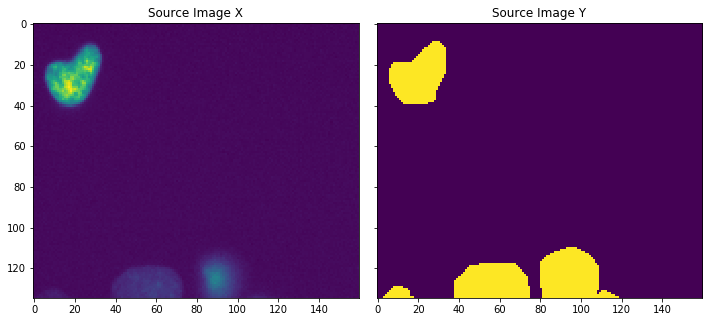

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

print(train_data.x.shape)

index = np.random.randint(low=0, high=train_data.x.shape[0])
frame = np.random.randint(low=0, high=train_data.x.shape[1])
print('Image number:', index)
print('Frame number:', frame)

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10, 5), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(train_data.x[index, frame, ..., 0])
ax[0].set_title('Source Image X')

ax[1].imshow(train_data.y[index, frame, ..., 1])
ax[1].set_title('Source Image Y')

fig.tight_layout()
plt.show()

## Train the Model

### Training Parameters

In [8]:
from tensorflow.keras.optimizers import SGD
from deepcell.utils.train_utils import rate_scheduler

fgbg_model_name = 'trackingSEG_cropped_conv_fgbg_model'
conv_model_name = 'trackingSEG_cropped_conv_watershed_model'

n_epoch = 5  # Number of training epochs
norm_method = 'whole_image'  # data normalization - `whole_image` for 3d conv
receptive_field = 61  # should be adjusted for the scale of the data

optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

lr_sched = rate_scheduler(lr=0.01, decay=0.99)

# FC training settings
n_skips = 3  # number of skip-connections (only for FC training)
batch_size = 1  # FC training uses 1 image per batch

# Transformation settings
transform = 'watershed'
distance_bins = 4  # number of distance classes
erosion_width = 1  # erode edges, improves segmentation when cells are close

# 3D Settings
frames_per_batch = 3

# GRU Settings
is_gru = False
gru_kernel_size = 3

### Foreground Background Model

#### (1) Instantiate the fgbg model

In [10]:
fgbg_model = feature_net_skip_3D(
            n_features=2,  # segmentation mask (is_cell, is_not_cell)
            receptive_field=receptive_field,
            n_skips=n_skips,
            n_conv_filters=32,
            n_dense_filters=128,
            gru=is_gru,
            gru_kernel_size=gru_kernel_size,
            input_shape=tuple([frames_per_batch] + list(train_dict['X'].shape[2:])),
            last_only=False,
            norm_method=norm_method)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 3, 135, 160,  0                                            
__________________________________________________________________________________________________
image_normalization3d (ImageNor (None, 3, 135, 160,  0           input_1[0][0]                    
__________________________________________________________________________________________________
model (Model)                   (None, 3, 135, 160,  213570      image_normalization3d[0][0]      
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 3, 135, 160,  0           image_normalization3d[0][0]      
                                                                 model[1][0]                      
__________

#### (2) Train the fgbg model

In [11]:
from deepcell.training import train_model_conv

fgbg_model = train_model_conv(
        model=fgbg_model,
        train_dict=train_dict,
        test_dict=test_dict,
        model_name=fgbg_model_name,
        log_dir=LOG_DIR,
        transform='fgbg',
        optimizer=optimizer,
        batch_size=batch_size,
        frames_per_batch=frames_per_batch,
        n_epoch=n_epoch,
        model_dir=MODEL_DIR,
        lr_sched=lr_sched,
        rotation_range=180,
        flip=True,
        shear=False,
        zoom_range=(0.8, 1.2))

fgbg_weights_file = os.path.join(MODEL_DIR, '{}.h5'.format(fgbg_model_name))
fgbg_model.save_weights(fgbg_weights_file)

X_train shape: (642, 30, 135, 160, 1)
y_train shape: (642, 30, 135, 160, 1)
X_test shape: (161, 30, 135, 160, 1)
y_test shape: (161, 30, 135, 160, 1)
Output Shape: (None, 3, 135, 160, 2)
Number of Classes: 2
Training on 1 GPUs
Epoch 1/5
641/642 [============================>.] - ETA: 0s - loss: 0.7067 - model_loss: 0.1737 - model_1_loss: 0.1658 - model_2_loss: 0.1641 - model_3_loss: 0.1564 - model_acc: 0.9234 - model_1_acc: 0.9266 - model_2_acc: 0.9266 - model_3_acc: 0.9310
Epoch 00001: val_loss improved from inf to 0.50586, saving model to /data/models/trackingSEG_cropped_conv_fgbg_model.h5
642/642 [==============================] - 366s 570ms/step - loss: 0.7059 - model_loss: 0.1735 - model_1_loss: 0.1656 - model_2_loss: 0.1639 - model_3_loss: 0.1562 - model_acc: 0.9235 - model_1_acc: 0.9267 - model_2_acc: 0.9267 - model_3_acc: 0.9311 - val_loss: 0.5059 - val_model_loss: 0.1220 - val_model_1_loss: 0.1187 - val_model_2_loss: 0.1111 - val_model_3_loss: 0.1072 - val_model_acc: 0.9666 - 

### Watershed energy transform

#### (1) Load weights for fgbg model if necessary

In [13]:
fgbg_model = feature_net_skip_3D(
            n_features=2,  # segmentation mask (is_cell, is_not_cell)
            receptive_field=receptive_field,
            n_skips=n_skips,
            n_conv_filters=32,
            n_dense_filters=128,
            gru=is_gru,
            gru_kernel_size=gru_kernel_size,
            input_shape=tuple([frames_per_batch] + list(train_dict['X'].shape[2:])),
            last_only=False)

fgbg_model.load_weights('/data/models/trackingSEG_cropped_conv_fgbg_model.h5')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           (None, 3, 135, 160,  0                                            
__________________________________________________________________________________________________
image_normalization3d_15 (Image (None, 3, 135, 160,  0           input_16[0][0]                   
__________________________________________________________________________________________________
model_15 (Model)                (None, 3, 135, 160,  213570      image_normalization3d_15[0][0]   
__________________________________________________________________________________________________
concatenate_9 (Concatenate)     (None, 3, 135, 160,  0           image_normalization3d_15[0][0]   
                                                                 model_15[1][0]                   
__________

#### (2) Instantiate the distance transform model 

In [12]:
# from deepcell import model_zoo

# watershed_model = model_zoo.bn_feature_net_skip_3D(
#     fgbg_model=fgbg_model,
#     receptive_field=receptive_field,
#     n_skips=n_skips,
#     n_features=distance_bins,
#     n_frames=frames_per_batch,
#     n_conv_filters=32,
#     n_dense_filters=128,
#     multires=False,
#     last_only=False,
#     input_shape=tuple([frames_per_batch] + list(X_train.shape[2:])),
#     norm_method='whole_image')

watershed_model = feature_net_skip_3D(
    fgbg_model=fgbg_model,
    receptive_field=receptive_field,
    n_skips=n_skips,
    n_features=distance_bins,  # (background edge, interior edge, cell interior, background)
    n_frames=frames_per_batch,
    n_conv_filters=32,
    n_dense_filters=128,
    gru=is_gru,
    gru_kernel_size=gru_kernel_size,
    multires=False,
    last_only=False,
    input_shape=tuple([frames_per_batch] + list(train_dict['X'].shape[2:])),
    norm_method=norm_method)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 3, 135, 160,  0                                            
__________________________________________________________________________________________________
image_normalization3d_5 (ImageN (None, 3, 135, 160,  0           input_6[0][0]                    
__________________________________________________________________________________________________
model_4 (Model)                 [(None, 3, 135, 160, 857352      input_6[0][0]                    
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (None, 3, 135, 160,  0           image_normalization3d_5[0][0]    
                                                                 model_4[1][3]                    
__________

#### (3) Train the distance transform model

In [13]:
watershed_model = train_model_conv(
        model=watershed_model,
        train_dict=train_dict,
        test_dict=test_dict,
        model_name=conv_model_name,
        test_size=test_size,
        seed=seed,
        transform=transform,
        distance_bins=distance_bins,
        erosion_width=erosion_width,
        optimizer=optimizer,
        batch_size=batch_size,
        n_epoch=n_epoch,
        frames_per_batch=frames_per_batch,
        model_dir=MODEL_DIR,
        lr_sched=lr_sched,
        rotation_range=180,
        flip=True,
        shear=False,
        zoom_range=(0.8, 1.2))

watershed_weights_file = os.path.join(MODEL_DIR, '{}.h5'.format(conv_model_name))
watershed_model.save_weights(watershed_weights_file)

X_train shape: (642, 30, 135, 160, 1)
y_train shape: (642, 30, 135, 160, 1)
X_test shape: (161, 30, 135, 160, 1)
y_test shape: (161, 30, 135, 160, 1)
Output Shape: (None, 3, 135, 160, 4)
Number of Classes: 4
Training on 1 GPUs
Epoch 1/5
641/642 [============================>.] - ETA: 0s - loss: 3.2458 - model_5_loss: 0.8078 - model_6_loss: 0.7833 - model_7_loss: 0.7890 - model_8_loss: 0.7689 - model_5_acc: 0.8392 - model_6_acc: 0.8396 - model_7_acc: 0.8383 - model_8_acc: 0.8390
Epoch 00001: val_loss improved from inf to 3.07554, saving model to /data/models/trackingSEG_cropped_conv_watershed_model.h5
642/642 [==============================] - 397s 618ms/step - loss: 3.2445 - model_5_loss: 0.8076 - model_6_loss: 0.7830 - model_7_loss: 0.7886 - model_8_loss: 0.7686 - model_5_acc: 0.8394 - model_6_acc: 0.8397 - model_7_acc: 0.8384 - model_8_acc: 0.8392 - val_loss: 3.0755 - val_model_5_loss: 0.8408 - val_model_6_loss: 0.6780 - val_model_7_loss: 0.7599 - val_model_8_loss: 0.6999 - val_model

# Run the model

#### Make predictions on test data

In [40]:
run_fgbg_model = feature_net_skip_3D(
            n_features=2,  # segmentation mask (is_cell, is_not_cell)
            receptive_field=receptive_field,
            n_skips=n_skips,
            n_conv_filters=32,
            n_dense_filters=128,
            gru=is_gru,
            gru_kernel_size=gru_kernel_size,
            input_shape=tuple(X_test.shape[1:]),
            last_only=False,
            norm_method=norm_method)

run_fgbg_model.load_weights('/data/models/trackingSEG_cropped_conv_fgbg_model.h5')

run_watershed_model = feature_net_skip_3D(
                        fgbg_model=run_fgbg_model,
                        receptive_field=receptive_field,
                        n_skips=n_skips,
                        n_features=distance_bins,
                        n_frames=frames_per_batch,
                        n_conv_filters=32,
                        n_dense_filters=128,
                        multires=False,
                        last_only=False,
                        input_shape=tuple(X_test.shape[1:]),
                        norm_method=norm_method,
                        gru=False,
                        gru_kernel_size=3)

run_watershed_model.load_weights('/data/models/trackingSEG_cropped_conv_watershed_model.h5')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_61 (InputLayer)           (None, 30, 135, 160, 0                                            
__________________________________________________________________________________________________
image_normalization3d_60 (Image (None, 30, 135, 160, 0           input_61[0][0]                   
__________________________________________________________________________________________________
model_60 (Model)                (None, 30, 135, 160, 213570      image_normalization3d_60[0][0]   
__________________________________________________________________________________________________
concatenate_39 (Concatenate)    (None, 30, 135, 160, 0           image_normalization3d_60[0][0]   
                                                                 model_60[1][0]                   
__________

In [15]:
# make predictions on testing data
test_images = run_watershed_model.predict(X_test[:6, :, :, :, :])[-1]
test_images_fgbg = run_fgbg_model.predict(X_test[:6, :, :, :, :])[-1]

print('watershed transform shape:', test_images.shape)
print('segmentation mask shape:', test_images_fgbg.shape)

watershed transform shape: (6, 30, 135, 160, 4)
segmentation mask shape: (6, 30, 135, 160, 2)


### Watershed post-processing

In [19]:
# Collapse predictions into semantic segmentation mask

argmax_images = []
for i in range(test_images.shape[0]):
    max_image = np.argmax(test_images[i], axis=-1)
    argmax_images.append(max_image)
argmax_images = np.array(argmax_images)
argmax_images = np.expand_dims(argmax_images, axis=-1)

print('watershed argmax shape:', argmax_images.shape)

watershed argmax shape: (6, 30, 135, 160, 1)


In [23]:
# threshold the foreground/background
# and remove background from watershed transform
threshold = 0.5
fg_thresh = test_images_fgbg[..., 1] > threshold

fg_thresh = np.expand_dims(fg_thresh.astype('int16'), axis=-1)
argmax_images_post_fgbg = argmax_images * fg_thresh

In [24]:
# Apply watershed method with the distance transform as seed
from skimage.measure import label
from skimage.morphology import watershed
from skimage.morphology import remove_small_objects
from skimage.feature import peak_local_max

watershed_images = []
for i in range(argmax_images_post_fgbg.shape[0]):
    image = fg_thresh[i, ..., 0]
    distance = argmax_images_post_fgbg[i, ..., 0]

    local_maxi = peak_local_max(test_images[i, ..., -1], min_distance=15, 
                                exclude_border=False, indices=False, labels=image)

    markers = label(local_maxi)
    segments = watershed(-distance, markers, mask=image)
    watershed_images.append(segments)

watershed_images = np.array(watershed_images)
watershed_images = remove_small_objects(watershed_images[:, :, :, :].astype('uint16'), min_size=400)
watershed_images = np.expand_dims(watershed_images, axis=-1)


### Plot the Results

Image number: 3
Frame: 1


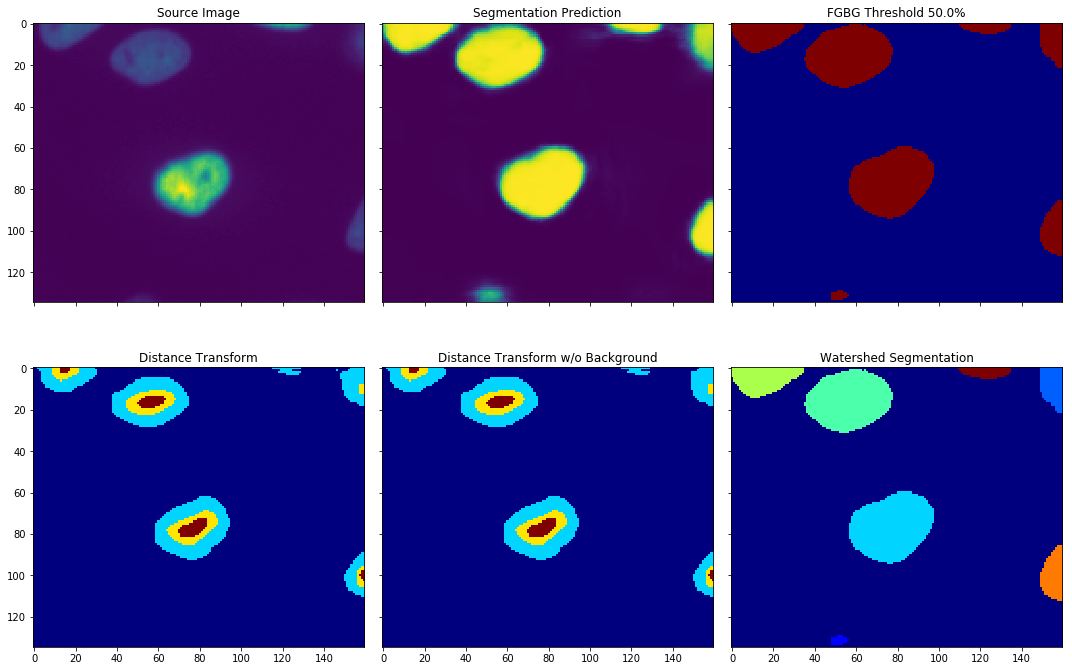

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

index = np.random.randint(low=0, high=6)
frame = np.random.randint(low=0, high=X_test.shape[1])
print('Image number:', index)
print('Frame:', frame)


fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(15, 10), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(X_test[index, frame, ..., 0])
ax[0].set_title('Source Image')

ax[1].imshow(test_images_fgbg[index, frame, ..., 1])
ax[1].set_title('Segmentation Prediction')

ax[2].imshow(fg_thresh[index, frame, ..., 0], cmap='jet')
ax[2].set_title('FGBG Threshold {}%'.format(threshold * 100))

ax[3].imshow(argmax_images[index, frame, ..., 0], cmap='jet')
ax[3].set_title('Distance Transform')

ax[4].imshow(argmax_images_post_fgbg[index, frame, ..., 0], cmap='jet')
ax[4].set_title('Distance Transform w/o Background')

ax[5].imshow(watershed_images[index, frame, ..., 0], cmap='jet')
ax[5].set_title('Watershed Segmentation')

fig.tight_layout()
plt.show()
# plt.savefig('test.png')

### Run the Model Iteratively

In [28]:
# Define the Datasets

###### For Deepcell Datasets

# Define data to load (raw images from trk test files)
RAW_BASE_DIR = '/data/npz_data/tracking_benchmark_data/test'

raw_trks_3T3  = os.path.join(RAW_BASE_DIR, '3T3_NIH_test_BData.trks')
raw_trks_HEK  = os.path.join(RAW_BASE_DIR, 'HEK293_generic_test_BData.trks')
raw_trks_HeLa = os.path.join(RAW_BASE_DIR, 'HeLa_S3_test_BData.trks')
raw_trks_RAW  = os.path.join(RAW_BASE_DIR, 'RAW264_generic_test_BData.trks')

# raw_trks_files = [raw_trks_3T3, raw_trks_HEK, raw_trks_HeLa]
raw_trks_files = [raw_trks_3T3, raw_trks_HEK, raw_trks_HeLa, raw_trks_RAW]

# Define a base file name for the output
BASE_NAME = 'batch_'

In [41]:
# Make predictions on test data
from deepcell.utils.tracking_utils import load_trks
from skimage.morphology import remove_small_objects
import pandas as pd
from deepcell import metrics
from skimage.measure import label
from skimage.morphology import watershed
from skimage.feature import peak_local_max

# CELL_TYPE_NAME = ['3T3', 'HEK293', 'HeLa']
CELL_TYPE_NAME = ['3T3', 'HEK293', 'HeLa', 'RAW264']

# threshold the foreground/background
# and remove back ground from edge transform
threshold = 0.5
Lstats_AllDatasets = []
# Go through each Dataset (3T3, HEK293, HeLa, RAW264.7)
for set_num, dataset in enumerate(raw_trks_files):
    # Load the trk file       
    trks = load_trks(dataset)
    lineages, raw, tracked = trks['lineages'], trks['X'], trks['y']
    
    run_fgbg_model = feature_net_skip_3D(
            n_features=2,  # segmentation mask (is_cell, is_not_cell)
            receptive_field=receptive_field,
            n_skips=n_skips,
            n_conv_filters=32,
            n_dense_filters=128,
            gru=is_gru,
            gru_kernel_size=gru_kernel_size,
            input_shape=tuple(trks['X'].shape[1:]),
            last_only=False,
            norm_method=norm_method)

    run_fgbg_model.load_weights('/data/models/trackingSEG_cropped_conv_fgbg_model.h5')

    run_watershed_model = feature_net_skip_3D(
                        fgbg_model=run_fgbg_model,
                        receptive_field=receptive_field,
                        n_skips=n_skips,
                        n_features=distance_bins,
                        n_frames=frames_per_batch,
                        n_conv_filters=32,
                        n_dense_filters=128,
                        multires=False,
                        last_only=False,
                        input_shape=tuple(trks['X'].shape[1:]),
                        norm_method=norm_method,
                        gru=False,
                        gru_kernel_size=3)

    run_watershed_model.load_weights('/data/models/trackingSEG_cropped_conv_watershed_model.h5')
    
    # Create an array for the new annotations
    y_new = np.zeros(tracked.shape)
    Lstats = []
    # Go through each batch (movie) in each dataset
    # Predict on the raw data
    for j in range(len(trks['y'])):
        X_test, y_test = trks['X'][j:j+1, ...], trks['y'][j:j+1,...]
        print("X_test.shape", X_test.shape)
        test_images = run_watershed_model.predict(X_test)[-1]
        test_images_fgbg = run_fgbg_model.predict(X_test)[-1]
        # Postprocessing
        # Collapse predictions into semantic segmentation mask
        argmax_images = []
        for i in range(test_images.shape[0]):
            max_image = np.argmax(test_images[i], axis=-1)
            argmax_images.append(max_image)
        argmax_images = np.array(argmax_images)
        argmax_images = np.expand_dims(argmax_images, axis=-1)
        # threshold the foreground/background
        # and remove background from watershed transform
        fg_thresh = test_images_fgbg[..., 1] > threshold
        fg_thresh = np.expand_dims(fg_thresh.astype('int16'), axis=-1)
        argmax_images_post_fgbg = argmax_images * fg_thresh
        watershed_images = []
        for i in range(argmax_images_post_fgbg.shape[0]):
            image = fg_thresh[i, ..., 0]
            distance = argmax_images_post_fgbg[i, ..., 0]
            local_maxi = peak_local_max(test_images[i, ..., -1], min_distance=15, 
                                        exclude_border=False, indices=False, labels=image)
            markers = label(local_maxi)
            segments = watershed(-distance, markers, mask=image)
            watershed_images.append(segments)
        watershed_images = np.array(watershed_images)
        watershed_images = np.expand_dims(watershed_images, axis=-1)
        print("watershed_images.shape", watershed_images.shape)
        # Accuracy from metrics package
        batch_num = j
        filename = CELL_TYPE_NAME[set_num] + BASE_NAME + '{}'.format(batch_num)
        # Remove small objects from GT for comparison
        small_objects_threshold=100        
        GT_image = remove_small_objects(tracked[j:j+1, :, :, :, 0].astype('uint16'), min_size=small_objects_threshold)
        print("GT_image.shape", GT_image.shape)
        #GT_image = tracked[batch_num, :, :, :, :].astype('uint16')
        m = metrics.Metrics(model_name = filename)
        m.calc_object_stats(GT_image, watershed_images[:,:,:,:, 0])
        #m.save_to_json(m.output)    
        Lstats.append(m.stats)                
    Lstats_AllDatasets.append(Lstats)
df_3T3    = pd.concat(Lstats_AllDatasets[0]) 
df_HEK293 = pd.concat(Lstats_AllDatasets[1])
df_HeLa   = pd.concat(Lstats_AllDatasets[2])
df_RAW264 = pd.concat(Lstats_AllDatasets[3])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_71 (InputLayer)           (None, 30, 154, 182, 0                                            
__________________________________________________________________________________________________
image_normalization3d_70 (Image (None, 30, 154, 182, 0           input_71[0][0]                   
__________________________________________________________________________________________________
model_70 (Model)                (None, 30, 154, 182, 213570      image_normalization3d_70[0][0]   
__________________________________________________________________________________________________
concatenate_46 (Concatenate)    (None, 30, 154, 182, 0           image_normalization3d_70[0][0]   
                                                                 model_70[1][0]                   
__________

watershed_images.shape (1, 30, 154, 182, 1)
GT_image.shape (1, 30, 154, 182)
INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 17
Number of predicted cells:	 21

Correct detections:  4	Recall: 23.529411764705884024806437082588672637939453125%
Incorrect detections: 17	Precision: 19.047619047619047449870777199976146221160888671875%

Gained detections: 15	Perc Error: 53.5714285714285693984493263997137546539306640625%
Missed detections: 12	Perc Error: 42.85714285714285409767398959957063198089599609375%
Merges: 0		Perc Error: 0%
Splits: 1		Perc Error: 3.571428571428571618895375650026835501194000244140625%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 1
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.90468725684072281989500652343849651515483856201171875 

X_test.shape (1, 30, 154, 182, 1)
watershed_i

watershed_images.shape (1, 30, 154, 182, 1)
GT_image.shape (1, 30, 154, 182)
INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 15
Number of predicted cells:	 25

Correct detections:  3	Recall: 20%
Incorrect detections: 22	Precision: 12%

Gained detections: 20	Perc Error: 62.5%
Missed detections: 11	Perc Error: 34.375%
Merges: 0		Perc Error: 0%
Splits: 1		Perc Error: 3.125%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 1
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.82478119100737945501577996765263378620147705078125 

X_test.shape (1, 30, 154, 182, 1)
watershed_images.shape (1, 30, 154, 182, 1)
GT_image.shape (1, 30, 154, 182)
INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 9

Correct detections:  1	Rec

watershed_images.shape (1, 30, 154, 182, 1)
GT_image.shape (1, 30, 154, 182)
INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 10
Number of predicted cells:	 16

Correct detections:  1	Recall: 10%
Incorrect detections: 15	Precision: 6.25%

Gained detections: 11	Perc Error: 55%
Missed detections: 7	Perc Error: 35%
Merges: 0		Perc Error: 0%
Splits: 2		Perc Error: 10%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 2
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.87727629073804458403884609651868231594562530517578125 

X_test.shape (1, 30, 154, 182, 1)
watershed_images.shape (1, 30, 154, 182, 1)
GT_image.shape (1, 30, 154, 182)
INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 17
Number of predicted cells:	 19

Correct detections:  4	Recall

watershed_images.shape (1, 30, 135, 160, 1)
GT_image.shape (1, 30, 135, 160)
INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 28
Number of predicted cells:	 22

Correct detections:  4	Recall: 14.2857142857142864755815026001073420047760009765625%
Incorrect detections: 18	Precision: 18.181818181818183433051672182045876979827880859375%

Gained detections: 16	Perc Error: 42.10526315789473983386415056884288787841796875%
Missed detections: 21	Perc Error: 55.26315789473684247923301882110536098480224609375%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 1		Perc Error: 2.631578947368421239616509410552680492401123046875%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 3
Predicted detections involved in catastrophes: 2 

Average Pixel IOU (Jaccard Index): 0.870597714981403925094127771444618701934814453125 

X_test.shape (1, 30, 135, 160, 1)
watershed_images.

watershed_images.shape (1, 30, 135, 160, 1)
GT_image.shape (1, 30, 135, 160)
INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 19
Number of predicted cells:	 21

Correct detections:  3	Recall: 15.7894736842105256613422170630656182765960693359375%
Incorrect detections: 18	Precision: 14.2857142857142864755815026001073420047760009765625%

Gained detections: 16	Perc Error: 50%
Missed detections: 15	Perc Error: 46.875%
Merges: 0		Perc Error: 0%
Splits: 1		Perc Error: 3.125%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 1
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8749432609381371239720692756236530840396881103515625 

X_test.shape (1, 30, 135, 160, 1)
watershed_images.shape (1, 30, 135, 160, 1)
GT_image.shape (1, 30, 135, 160)
INFO:tensorflow:0 samples processed

____________Object-based statist

watershed_images.shape (1, 30, 135, 160, 1)
GT_image.shape (1, 30, 135, 160)
INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 21
Number of predicted cells:	 26

Correct detections:  5	Recall: 23.8095238095238102005168912000954151153564453125%
Incorrect detections: 21	Precision: 19.230769230769229949373766430653631687164306640625%

Gained detections: 18	Perc Error: 54.5454545454545467464413377456367015838623046875%
Missed detections: 13	Perc Error: 39.3939393939393909249702119268476963043212890625%
Merges: 1		Perc Error: 3.03030303030303027611580546363256871700286865234375%
Splits: 1		Perc Error: 3.03030303030303027611580546363256871700286865234375%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 1
Missed detections from merges: 1
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.87581737084458044506618534796871244907379150390625 

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_96 (InputLayer)           (None, 40, 216, 256, 0                                            
__________________________________________________________________________________________________
image_normalization3d_95 (Image (None, 40, 216, 256, 0           input_96[0][0]                   
__________________________________________________________________________________________________
model_94 (Model)                [(None, 40, 216, 256 857352      input_96[0][0]                   
__________________________________________________________________________________________________
concatenate_63 (Concatenate)    (None, 40, 216, 256, 0           image_normalization3d_95[0][0]   
                                                                 model_94[1][3]                   
__________

watershed_images.shape (1, 40, 216, 256, 1)
GT_image.shape (1, 40, 216, 256)
INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 8
Number of predicted cells:	 20

Correct detections:  0	Recall: 0%
Incorrect detections: 20	Precision: 0%

Gained detections: 18	Perc Error: 69.23076923076922639666008763015270233154296875%
Missed detections: 7	Perc Error: 26.923076923076923350208744523115456104278564453125%
Merges: 0		Perc Error: 0%
Splits: 1		Perc Error: 3.846153846153846256328279196168296039104461669921875%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 1
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.80287175682798739284606881483341567218303680419921875 

X_test.shape (1, 40, 216, 256, 1)
watershed_images.shape (1, 40, 216, 256, 1)
GT_image.shape (1, 40, 216, 256)
INFO:tensorflow:0 samples processe

watershed_images.shape (1, 40, 216, 256, 1)
GT_image.shape (1, 40, 216, 256)
INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 6
Number of predicted cells:	 12

Correct detections:  1	Recall: 16.666666666666667850904559600166976451873779296875%
Incorrect detections: 11	Precision: 8.3333333333333339254522798000834882259368896484375%

Gained detections: 11	Perc Error: 68.75%
Missed detections: 5	Perc Error: 31.25%
Merges: 0		Perc Error: 0%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8453005627905711971692426232038997113704681396484375 

X_test.shape (1, 40, 216, 256, 1)
watershed_images.shape (1, 40, 216, 256, 1)
GT_image.shape (1, 40, 216, 256)
INFO:tensorflow:0 samples processed

____________Object-based statistics___

INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 43
Number of predicted cells:	 40

Correct detections:  3	Recall: 6.9767441860465115865963525720871984958648681640625%
Incorrect detections: 37	Precision: 7.5%

Gained detections: 36	Perc Error: 48%
Missed detections: 38	Perc Error: 50.66666666666666429819088079966604709625244140625%
Merges: 1		Perc Error: 1.3333333333333332593184650249895639717578887939453125%
Splits: 0		Perc Error: 0%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 0
Missed detections from merges: 1
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.872960733821171341872968696407042443752288818359375 

X_test.shape (1, 30, 202, 240, 1)
watershed_images.shape (1, 30, 202, 240, 1)
GT_image.shape (1, 30, 202, 240)
INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cel

watershed_images.shape (1, 30, 202, 240, 1)
GT_image.shape (1, 30, 202, 240)
INFO:tensorflow:0 samples processed

____________Object-based statistics____________

Number of true cells:		 31
Number of predicted cells:	 32

Correct detections:  3	Recall: 9.6774193548387099639285224839113652706146240234375%
Incorrect detections: 29	Precision: 9.375%

Gained detections: 26	Perc Error: 48.14814814814814525334440986625850200653076171875%
Missed detections: 27	Perc Error: 50%
Merges: 0		Perc Error: 0%
Splits: 1		Perc Error: 1.8518518518518518600757261083344928920269012451171875%
Catastrophes: 0		Perc Error: 0%

Gained detections from splits: 2
Missed detections from merges: 0
True detections involved in catastrophes: 0
Predicted detections involved in catastrophes: 0 

Average Pixel IOU (Jaccard Index): 0.8865202242275260768877842565416358411312103271484375 

X_test.shape (1, 30, 202, 240, 1)
watershed_images.shape (1, 30, 202, 240, 1)
GT_image.shape (1, 30, 202, 240)
INFO:tensorflow:0 sample

In [42]:
# CELL_TYPE_DF = [df_3T3, df_HEK293, df_HeLa]

CELL_TYPE_DF = [df_3T3, df_HEK293, df_HeLa, df_RAW264]

for cell_type, df in zip(CELL_TYPE_NAME, CELL_TYPE_DF):
    print('\n')
    print(cell_type)
    print('\n')
    # Total number of correct detections and incorrect detections
    correct_det = int(df['correct_detections'].sum())
    incorrect_det = int(df['n_pred'].sum() - df['correct_detections'].sum())

    print('Correct Detections: ', correct_det)
    print('Incorrect Detections: ', incorrect_det)
    
    # Total number of splits, merges, and catastrophes
    splits = df['split'].sum()
    merges = df['merge'].sum()
    catastrophes = df['catastrophe'].sum()
    
    print('Splits: ', splits)
    print('Merges: ', merges)
    print('Catastrophes: ', catastrophes)

    # Average Recall, Precision, and Jaccard Index
    recall = 100 * df['correct_detections'].sum() / df['n_true'].sum()
    precision = 100 * df['correct_detections'].sum() / df['n_pred'].sum()
    jaccard = df['jaccard'].mean()

    print('Recall: ', recall)
    print('Precision: ', precision)
    print('Average Jaccard Index: ', jaccard)



3T3


Correct Detections:  55
Incorrect Detections:  306
Splits:  11
Merges:  1
Catastrophes:  0
Recall:  19.09722222222222
Precision:  15.23545706371191
Average Jaccard Index:  0.8450120014516203


HEK293


Correct Detections:  100
Incorrect Detections:  468
Splits:  19
Merges:  10
Catastrophes:  7
Recall:  17.094017094017094
Precision:  17.6056338028169
Average Jaccard Index:  0.8760236436107901


HeLa


Correct Detections:  27
Incorrect Detections:  236
Splits:  8
Merges:  0
Catastrophes:  0
Recall:  15.976331360946746
Precision:  10.26615969581749
Average Jaccard Index:  0.8213110539148611


RAW264


Correct Detections:  27
Incorrect Detections:  209
Splits:  4
Merges:  1
Catastrophes:  3
Recall:  12.857142857142858
Precision:  11.440677966101696
Average Jaccard Index:  0.8555789776118606


## See what it looks like on the different data sets

In [43]:
RAW_BASE_DIR = '/data/npz_data/tracking_benchmark_data/test'

raw_trks_3T3  = os.path.join(RAW_BASE_DIR, '3T3_NIH_test_BData.trks')
raw_trks_HEK  = os.path.join(RAW_BASE_DIR, 'HEK293_generic_test_BData.trks')
raw_trks_HeLa = os.path.join(RAW_BASE_DIR, 'HeLa_S3_test_BData.trks')
raw_trks_RAW  = os.path.join(RAW_BASE_DIR, 'RAW264_generic_test_BData.trks')

#### Predict on dataset

In [ ]:
from deepcell.utils.tracking_utils import load_trks
from skimage.morphology import remove_small_objects
import pandas as pd
from deepcell import metrics
from skimage.measure import label
from skimage.morphology import watershed
from skimage.feature import peak_local_max

trks = load_trks(raw_trks_HeLa)
lineages, X_test, y_test = trks['lineages'], trks['X'], trks['y']

run_fgbg_model = feature_net_skip_3D(
            n_features=2,  # segmentation mask (is_cell, is_not_cell)
            receptive_field=receptive_field,
            n_skips=n_skips,
            n_conv_filters=32,
            n_dense_filters=128,
            gru=is_gru,
            gru_kernel_size=gru_kernel_size,
            input_shape=tuple(X_test.shape[1:]),
            last_only=False,
            norm_method=norm_method)

run_fgbg_model.load_weights('/data/models/trackingSEG_cropped_conv_fgbg_model.h5')

run_watershed_model = feature_net_skip_3D(
                    fgbg_model=run_fgbg_model,
                    receptive_field=receptive_field,
                    n_skips=n_skips,
                    n_features=distance_bins,
                    n_frames=frames_per_batch,
                    n_conv_filters=32,
                    n_dense_filters=128,
                    multires=False,
                    last_only=False,
                    input_shape=tuple(X_test.shape[1:]),
                    norm_method=norm_method,
                    gru=False,
                    gru_kernel_size=3)

run_watershed_model.load_weights('/data/models/trackingSEG_cropped_conv_watershed_model.h5')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_141 (InputLayer)          (None, 40, 216, 256, 0                                            
__________________________________________________________________________________________________
image_normalization3d_140 (Imag (None, 40, 216, 256, 0           input_141[0][0]                  
__________________________________________________________________________________________________
model_140 (Model)               (None, 40, 216, 256, 213570      image_normalization3d_140[0][0]  
__________________________________________________________________________________________________
concatenate_95 (Concatenate)    (None, 40, 216, 256, 0           image_normalization3d_140[0][0]  
                                                                 model_140[1][0]                  
__________

In [ ]:
# make predictions on testing data
test_images = run_watershed_model.predict(X_test[:2, :, :, :, :])[-1]
test_images_fgbg = run_fgbg_model.predict(X_test[:2, :, :, :, :])[-1]

print('watershed transform shape:', test_images.shape)
print('segmentation mask shape:', test_images_fgbg.shape)

#### Post-process

In [ ]:
# Collapse predictions into semantic segmentation mask

argmax_images = []
for i in range(test_images.shape[0]):
    max_image = np.argmax(test_images[i], axis=-1)
    argmax_images.append(max_image)
argmax_images = np.array(argmax_images)
argmax_images = np.expand_dims(argmax_images, axis=-1)

print('watershed argmax shape:', argmax_images.shape)

# threshold the foreground/background
# and remove background from watershed transform
threshold = 0.5
fg_thresh = test_images_fgbg[..., 1] > threshold

fg_thresh = np.expand_dims(fg_thresh.astype('int16'), axis=-1)
argmax_images_post_fgbg = argmax_images * fg_thresh

In [ ]:
# Apply watershed method with the distance transform as seed
from skimage.measure import label
from skimage.morphology import watershed
from skimage.morphology import remove_small_objects
from skimage.feature import peak_local_max

watershed_images = []
for i in range(argmax_images_post_fgbg.shape[0]):
    image = fg_thresh[i, ..., 0]
    distance = argmax_images_post_fgbg[i, ..., 0]

    local_maxi = peak_local_max(test_images[i, ..., -1], min_distance=15, 
                                exclude_border=False, indices=False, labels=image)

    markers = label(local_maxi)
    segments = watershed(-distance, markers, mask=image)
    watershed_images.append(segments)

watershed_images = np.array(watershed_images)
# watershed_images = remove_small_objects(watershed_images[:, :, :, :].astype('uint16'), min_size=400)
watershed_images = np.expand_dims(watershed_images, axis=-1)


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

index = np.random.randint(low=0, high=2)
frame = np.random.randint(low=0, high=X_test.shape[1])
print('Image number:', index)
print('Frame:', frame)



fig, axes = plt.subplots(ncols=4, nrows=2, figsize=(15, 10), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(X_test[index, frame, ..., 0])
ax[0].set_title('Source Image')

ax[1].imshow(test_images_fgbg[index, frame, ..., 1])
ax[1].set_title('Segmentation Prediction')

ax[2].imshow(fg_thresh[index, frame, ..., 0], cmap='jet')
ax[2].set_title('FGBG Threshold {}%'.format(threshold * 100))

fg_thresh_90 = test_images_fgbg[..., 1] > 0.5
fg_thresh_90 = np.expand_dims(fg_thresh_90.astype('int16'), axis=-1)
ax[3].imshow(fg_thresh_90[index, frame, ..., 0], cmap='jet')
ax[3].set_title('FGBG Threshold {}%'.format(0.5 * 100))

ax[4].imshow(argmax_images[index, frame, ..., 0], cmap='jet')
ax[4].set_title('Distance Transform')

ax[5].imshow(argmax_images_post_fgbg[index, frame, ..., 0], cmap='jet')
ax[5].set_title('Distance Transform w/o Background')

ax[6].imshow(watershed_images[index, frame, ..., 0], cmap='jet')
ax[6].set_title('Watershed Segmentation')

ax[7].imshow(y_test[index, frame, ..., 0], cmap='jet')
ax[7].set_title('Ground truth')

fig.tight_layout()
plt.show()
# plt.savefig('test.png')

### Make Predictions on ISBI Data for Metrics

In [ ]:
###### FOR ISBI Challenge Datasets

# Define data to load (raw images from trk test files)  
RAW_BASE_DIR = '/data/data/ISBI_Tracking_Challenge/tracks'

raw_trks_HeLa = os.path.join(RAW_BASE_DIR, 'ISBI_HeLa_Chal_GT.trks')
raw_trks_MSC  = os.path.join(RAW_BASE_DIR, 'ISBI_MSC_resized_Chal_GT_normalized.trks')
raw_trks_U373 = os.path.join(RAW_BASE_DIR, 'ISBI_U373_Chal_GT.trks')

#raw_trks_files = [raw_trks_HeLa, raw_trks_MSC, raw_trks_U373]
raw_trks_files = [raw_trks_HeLa]

# Define where segmentations will be saved
SEG_BASE_DIR = '/data/track_data/Final_Benchmarks/ISBI_DC_SEG/Watershed/HeLa_segmentations'
                             
DC_seg_HeLa  = os.path.join(SEG_BASE_DIR, 'HeLa/')
DC_seg_MSC   = os.path.join(SEG_BASE_DIR, 'MSC/')
DC_seg_U373  = os.path.join(SEG_BASE_DIR, 'U373/')

#DC_seg_folders = [DC_seg_HeLa, DC_seg_MSC, DC_seg_U373]
DC_seg_folders = [DC_seg_HeLa]

# Define a base file name for the output
BASE_NAME = 'batch_'

In [ ]:
# Instantiate new models for any image size

from deepcell import model_zoo

fgbg_model = model_zoo.bn_feature_net_skip_2D(
    n_features=2,  # segmentation mask (is_cell, is_not_cell)
    receptive_field=receptive_field,
    n_skips=n_skips,
    n_conv_filters=32,
    n_dense_filters=128,
    input_shape=(None, None, 1),
    last_only=False)

fgbg_model.load_weights('/data/models/trackingSEG_cropped_conv_gru_fgbg_model.h5')


watershed_model = model_zoo.bn_feature_net_skip_2D(
    fgbg_model=fgbg_model,
    receptive_field=receptive_field,
    n_skips=n_skips,
    n_features=distance_bins,
    n_conv_filters=32,
    n_dense_filters=128,
    last_only=False,
    input_shape=(None, None, 1))

watershed_model.load_weights('/data/models/trackingSEG_cropped_conv_gru_watershed_model.h5')

In [ ]:
# Run Predict for metric information only

CELL_TYPE_NAME = ['HeLa']
threshold = 0.9

from deepcell import metrics
from skimage.measure import label
from skimage import morphology
from skimage.morphology import watershed
from skimage.feature import peak_local_max

import tarfile
import pathlib
import tempfile
import json
import pandas as pd
from io import BytesIO


def load_trks(filename):
    """Load a trk/trks file.

    Args:
        trks_file: full path to the file including .trk/.trks

    Returns:
        A dictionary with raw, tracked, and lineage data
    """
    with tarfile.open(filename, 'r') as trks:

        # numpy can't read these from disk...
        array_file = BytesIO()
        array_file.write(trks.extractfile('raw.npy').read())
        array_file.seek(0)
        raw = np.load(array_file)
        array_file.close()

        array_file = BytesIO()
        array_file.write(trks.extractfile('tracked.npy').read())
        array_file.seek(0)
        tracked = np.load(array_file)
        array_file.close()

    return {'X': raw, 'y': tracked}


Lstats_AllDatasets = []

# Go through each Dataset
for set_num, dataset in enumerate(raw_trks_files):
    # Load the trk file       
    trks = load_trks(dataset)
    raw, tracked = trks['X'], trks['y']
    
    # Create an array for the new annotations
    y_new = np.zeros(tracked.shape)
                
    Lstats_allmovies = []

    # Go through each batch (movie) in each dataset
    for batch_num, movie in enumerate(trks['X']):

        Lstats = []
        # Predict on the raw data
        for frame_num, frame in enumerate(movie):
            
            image = np.expand_dims(frame, axis=0)
             
            test_image = watershed_model.predict(image)[-1]
            test_image_fgbg = fgbg_model.predict(image)[-1]

            # Postprocessing
            # Collapse predictions into semantic segmentation mask        
            max_image = np.argmax(test_image, axis=-1)
            argmax_image = np.expand_dims(max_image, axis=-1)
        
            # threshold the foreground/background
            # and remove background from watershed transform
            fg_thresh = test_image_fgbg[..., 1] > threshold

            fg_thresh = np.expand_dims(fg_thresh.astype('int16'), axis=-1)
            argmax_image_post_fgbg = argmax_image * fg_thresh
        
            # Apply watershed method with the distance transform as seed
            image = fg_thresh[..., 0]
            distance = argmax_image_post_fgbg[..., 0]

            local_maxi = peak_local_max(test_image[..., -1], min_distance=15, 
                                        exclude_border=False, indices=False, labels=image)

            markers = label(local_maxi)
            segments = watershed(-distance, markers, mask=image)
            watershed_image = np.expand_dims(segments, axis=-1)
            
            # Remove small objects from GT for comparison
            small_objects_threshold=50
            GT_image = trks['y'][batch_num, frame_num, :, :, :]
            GT_image = np.expand_dims(GT_image, axis=0)
            GT_image = morphology.remove_small_objects(GT_image.astype('uint16'), min_size=small_objects_threshold)
            
            # Accuracy from metrics package
            filename = CELL_TYPE_NAME[set_num] + BASE_NAME + '{}'.format(batch_num)
            
            m = metrics.Metrics(model_name = filename)
            m.calc_object_stats(GT_image, watershed_image)
            
            # Store results
            y_new[batch_num, frame_num, :, :, :] = watershed_image

            Lstats.append(m.stats)
            
    # Save results of this batch before moving on to the next
    filename = os.path.join(DC_seg_folders[set_num], 'all_batches.trks')
    filename = pathlib.Path(filename)

    with tarfile.open(str(filename), 'w') as trks:
        with tempfile.NamedTemporaryFile() as raw_file:
            np.save(raw_file, raw)
            raw_file.flush()
            trks.add(raw_file.name, 'raw.npy')

        with tempfile.NamedTemporaryFile() as tracked_file:
            np.save(tracked_file, y_new)
            tracked_file.flush()
            trks.add(tracked_file.name, 'tracked.npy')
                
        
        Lstats_allmovies.append(Lstats)
        
    Lstats_AllDatasets.append(Lstats_allmovies)
    
    
#df_HeLa   = pd.concat(Lstats_AllDatasets[0])
df_HeLa = pd.concat([pd.concat(Lstats_AllDatasets[0][0]) , pd.concat(Lstats_AllDatasets[0][1])])


In [ ]:
CELL_TYPE_DF = [df_HeLa]

for cell_type, df in zip(CELL_TYPE_NAME, CELL_TYPE_DF):
    print('\n')
    print(cell_type)
    print('\n')
    # Total number of correct detections and incorrect detections
    correct_det = int(df['correct_detections'].sum())
    incorrect_det = int(df['n_pred'].sum() - df['correct_detections'].sum())

    print('Correct Detections: ', correct_det)
    print('Incorrect Detections: ', incorrect_det)
    
    # Total number of splits, merges, and catastrophes
    splits = df['split'].sum()
    merges = df['merge'].sum()
    catastrophes = df['catastrophe'].sum()
    
    print('Splits: ', splits)
    print('Merges: ', merges)
    print('Catastrophes: ', catastrophes)

    # Average Recall, Precision, and Jaccard Index
    recall = 100 * df['correct_detections'].sum() / df['n_true'].sum()
    precision = 100 * df['correct_detections'].sum() / df['n_pred'].sum()
    jaccard = df['jaccard'].mean()

    print('Recall: ', recall)
    print('Precision: ', precision)
    print('Average Jaccard Index: ', jaccard)